# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [4]:
pip install torch

117.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Using cached torch-2.7.1-cp312-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.7.1-cp312-none-macosx_11_0_arm64.whl (68.6 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install opencv-python
%pip install matplotlib
%pip install pandas

312.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 5.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
326.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
333.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install efficientnet_pytorch
%pip install torchvision
%pip install albumentations

import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet, weights  # Ensure 'architectures' is in the parent directory
try:
	from isplutils import utils
except ImportError:
	print("Ensure 'isplutils' is correctly installed and accessible.")

471.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
478.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
486.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached stringzilla-3.12.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (80 kB)
  Using cached simsimd-6.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (66 kB)
  Using cached pydantic_core-2.33.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.

## Parameters

In [83]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
#net_model = 'EfficientNetB4ST'  # or 'EfficientNetB4', 'EfficientNetAutoAttB4', 'EfficientNetAutoAttB4ST', 'Xception'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'  # Use 'FFPP' for FaceForensics++, not 'DFDC' or 'celebdf'

net_model = 'EfficientNetAutoAttB4'  # or 'EfficientNetB4', 'Xception', etc.
#train_db = 'celebdf'  # Use 'celebdf' for Celeb-DF, not 'DFDC' or 'FFPP'


In [84]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
face_policy = 'scale'
face_size = 224
frames_per_video = 32

Using device: mps


## Initialization

In [85]:
key = '{:s}_{:s}'.format(net_model, train_db)
if key not in weights.weight_url:
	raise KeyError(f"Key '{key}' not found in weights.weight_url. Available keys are: {list(weights.weight_url.keys())}")

model_url = weights.weight_url[key]
net = getattr(fornet, net_model)().eval().to(device)
net.load_state_dict(load_url(model_url, map_location=device, check_hash=True))

Loaded pretrained weights for efficientnet-b4
Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /Users/anmolsen/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth


100%|██████████| 33.9M/33.9M [00:05<00:00, 6.67MB/s]


<All keys matched successfully>

In [86]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

/Users/anmolsen/Documents/icpr2020/icpr2020dfdc/notebook/../isplutils/utils.py:155: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=patch_size, min_width=patch_size,
/Users/anmolsen/Documents/icpr2020/icpr2020dfdc/notebook/../isplutils/utils.py:157: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=patch_size,width=patch_size,always_apply=True),


In [89]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

In [90]:
vid_real_faces = face_extractor.process_video('/Users/anmolsen/Documents/icpr2020/icpr2020dfdc/datasets/celebdf_v2/Celeb-real/id0_0001.mp4')
vid_fake_faces = face_extractor.process_video('/Users/anmolsen/Documents/icpr2020/icpr2020dfdc/datasets/celebdf_v2/Celeb-synthesis/id0_id26_0001.mp4')

In [91]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

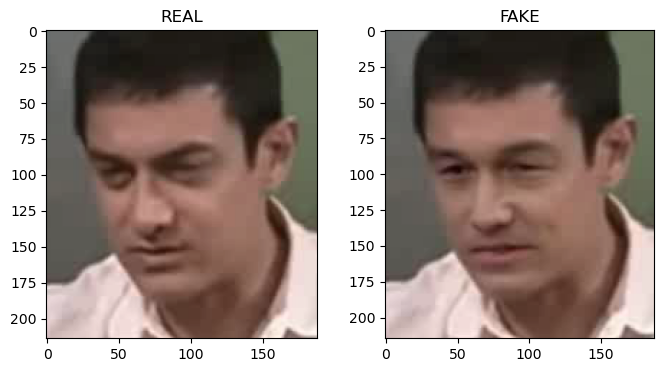

In [92]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [93]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

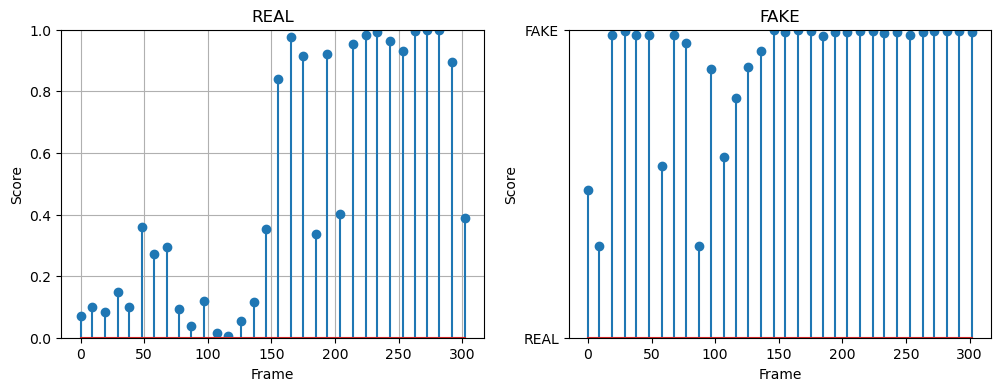

In [94]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])], expit(faces_real_pred))
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])], expit(faces_fake_pred))
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [95]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.5866
Average score for FAKE face: 0.9756
